# MOFA-FLEX vs MOFA on CLL Data

In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
import mofaflex as mfl
from plotnine import *
from data_loader import load_cll

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
mofa_model = mofa.mofa_model("models/mofa.h5")

z_mofa = pd.DataFrame(
    mofa_model.factors['group1'][:].T,
    index=mofa_model.samples['group1'],
    columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)],
) / 10

w_mofa = {}
for view in mofa_model.views:
    w_mofa[view] = pd.DataFrame(
        mofa_model.weights[view][:].T,
        index=mofa_model.features[view],
        columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)]
    ) * 10

r2_mofa = mofa_model.get_variance_explained().drop(columns="Group")
r2_mofa.replace({"Factor": {f"Factor{i}": f"{i}" for i in range(1, mofa_model.nfactors + 1)}}, inplace=True)
r2_mofa["Factor"] = pd.Categorical(r2_mofa["Factor"], categories=[f"{i+1}" for i in range(mofa_model.nfactors)], ordered=True)
r2_mofa["R2"] = r2_mofa["R2"] / 100

In [11]:
z_mofaflex = {}
w_mofaflex = {}
r2_mofaflex = {}
mofaflex_model = {}

for seed in range(10):
    mofaflex_model[seed] = mfl.MOFAFLEX.load(f"models/mofaflex_{seed}")
    z_mofaflex[seed] = mofaflex_model[seed].get_factors()['group_1']
    w_mofaflex[seed] = {}
    for view in mofaflex_model[0].view_names:
        w_mofaflex[seed][view] = mofaflex_model[seed].get_weights()[view].T
    r2_mofaflex[seed] = mofaflex_model[seed].get_r2()['group_1'].reset_index(names="Factor").melt(id_vars="Factor", var_name="View", value_name="R2")
    r2_mofaflex[seed].replace({"Factor": {f"Factor {i}": f"{i}" for i in range(1, mofa_model.nfactors + 1)}}, inplace=True)
    r2_mofaflex[seed]["Factor"] = pd.Categorical(r2_mofaflex[seed]["Factor"], categories=[f"{i+1}" for i in range(mofaflex_model[seed].n_factors)], ordered=True)

### Factor matching based on correlation

In [12]:
for seed in range(10):
    z_mofa_inds, z_mofaflex_inds, z_signs = mfl.tl.match(z_mofa.values, z_mofaflex[seed].values, axis=-1)

    z_mofaflex[seed] = z_mofaflex[seed].iloc[:, z_mofaflex_inds]
    z_mofaflex[seed] = z_mofaflex[seed] * z_signs.reshape(1, -1)
    z_mofaflex[seed].columns = [f"Factor {i+1}" for i in range(z_mofaflex[seed].shape[1])]

    for view in w_mofaflex[seed].keys():
        w_mofaflex[seed][view] = w_mofaflex[seed][view].iloc[:, z_mofaflex_inds]
        w_mofaflex[seed][view] = w_mofaflex[seed][view] * z_signs.reshape(1, -1)
        w_mofaflex[seed][view].columns = [f"Factor {i+1}" for i in range(w_mofaflex[seed][view].shape[1])]

    replace_dict = {f"{j+1}" : f"{i+1}" for i, j in enumerate(z_mofaflex_inds)}
    r2_mofaflex[seed].replace({"Factor" : replace_dict}, inplace=True)

### Correlation plots

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/correlations.pdf


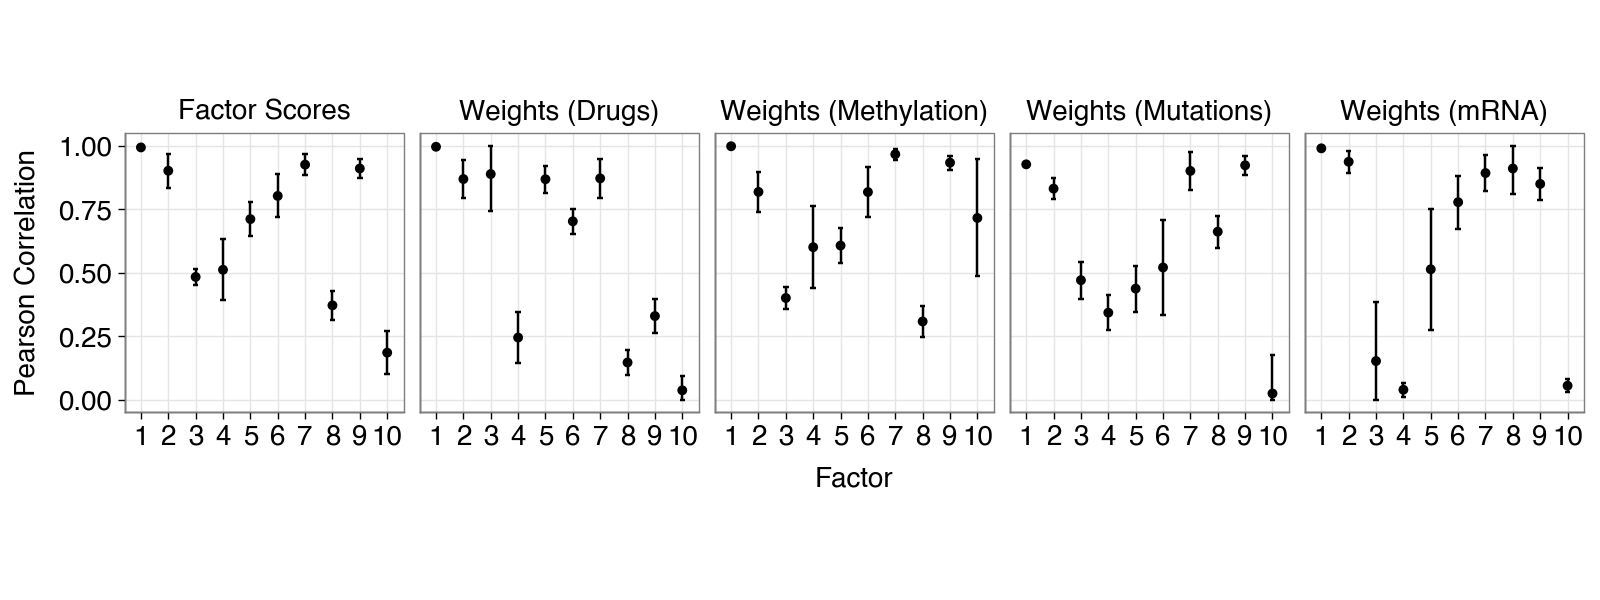

In [20]:
seeds = list(z_mofaflex.keys())
views = list(w_mofaflex[seeds[0]].keys())
n_factors = z_mofaflex[0].shape[1]

df = []
for seed in seeds:
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(z_mofaflex[seed].iloc[:, i], z_mofa.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Factor Scores"

    for view in views:
        corr = []
        for i in range(n_factors):
            corr.append(pearsonr(w_mofaflex[seed][view].iloc[:, i], w_mofa[view].iloc[:, i])[0].item())
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(n_factors)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0., a_max=1.)
df["max"] = np.clip(df["max"], a_min=0., a_max=1.)

plot = (
    ggplot(df, aes(x="factor", y="mean", group="lv"))
    + geom_point(size=1.)
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=5)
    + theme(
        figure_size=(8, 3),
    )
    + labs(x="Factor", y="Pearson Correlation", title="")
    + ylim(0, 1)
)

ggsave(plot, "plots/correlations.pdf")
plot.show()

### Weights scatter plots

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 4 x 3 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/mutations_weights.pdf


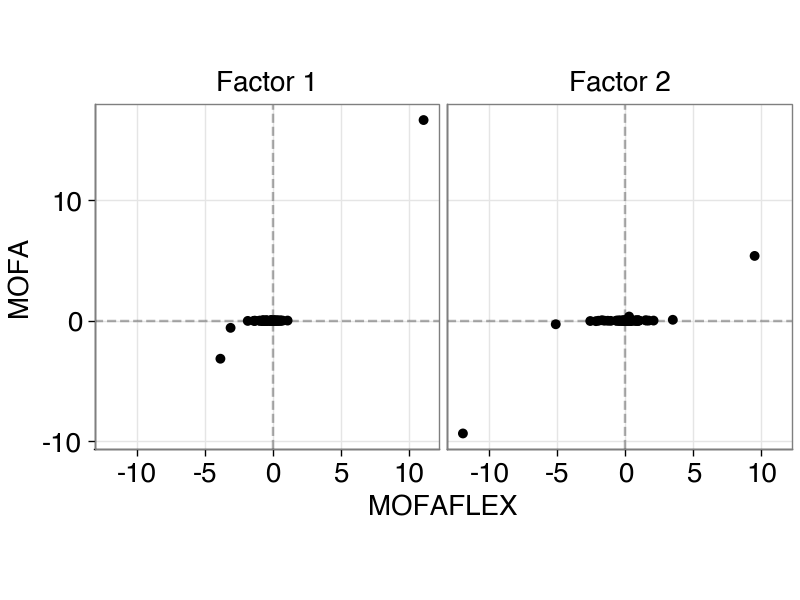

In [24]:
factors = ["Factor 1", "Factor 2"]
view = "Mutations"
seed = 0

df_list = []
for factor in factors:
    df_temp = pd.DataFrame({
        "weight_mofaflex": w_mofaflex[seed][view][factor],
        "weight_mofa": w_mofa[view][factor],
        "factor": factor
    })
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

plot = (
    ggplot(df, aes(x="weight_mofaflex", y="weight_mofa"))
    + geom_point(size=1.)
    + labs(x="MOFAFLEX", y="MOFA", title=f"")
    + theme(figure_size=(4, 3), plot_title=element_text(ha='center'))
    + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
    + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    + facet_wrap("~factor", scales="fixed")
)

ggsave(plot, f"plots/mutations_weights.pdf")
plot.show()

### Variance explained plots

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 4 x 3 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/variance_explained.pdf


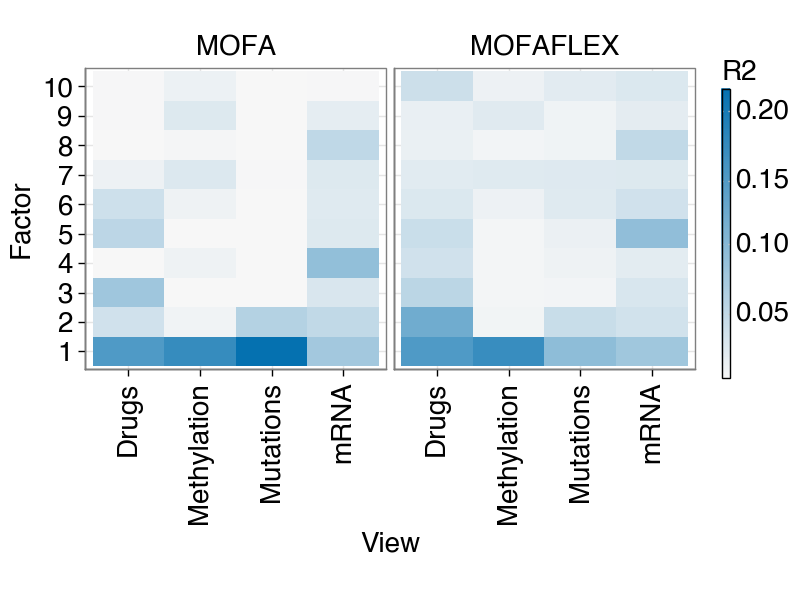

In [30]:
seed = 0

r2_mofaflex[seed]["model"] = "MOFAFLEX"
r2_mofa["model"] = "MOFA"
df = pd.concat([r2_mofaflex[seed], r2_mofa], ignore_index=True)
plot = (
    ggplot(df, aes(x="View", y="Factor", fill="R2", group="model"))
    + geom_tile()
    + scale_fill_gradient(low="#f7f7f7", high="#0571b0", name="R2")
    + labs(x="View", y="Factor", title="", fill="R2")
    + theme(axis_text_x=element_text(rotation=90), figure_size=(4, 3), legend_key_width=3.)
    + facet_wrap("~model")
)

ggsave(plot, f"plots/variance_explained.pdf")
plot.show()

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 4 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: 

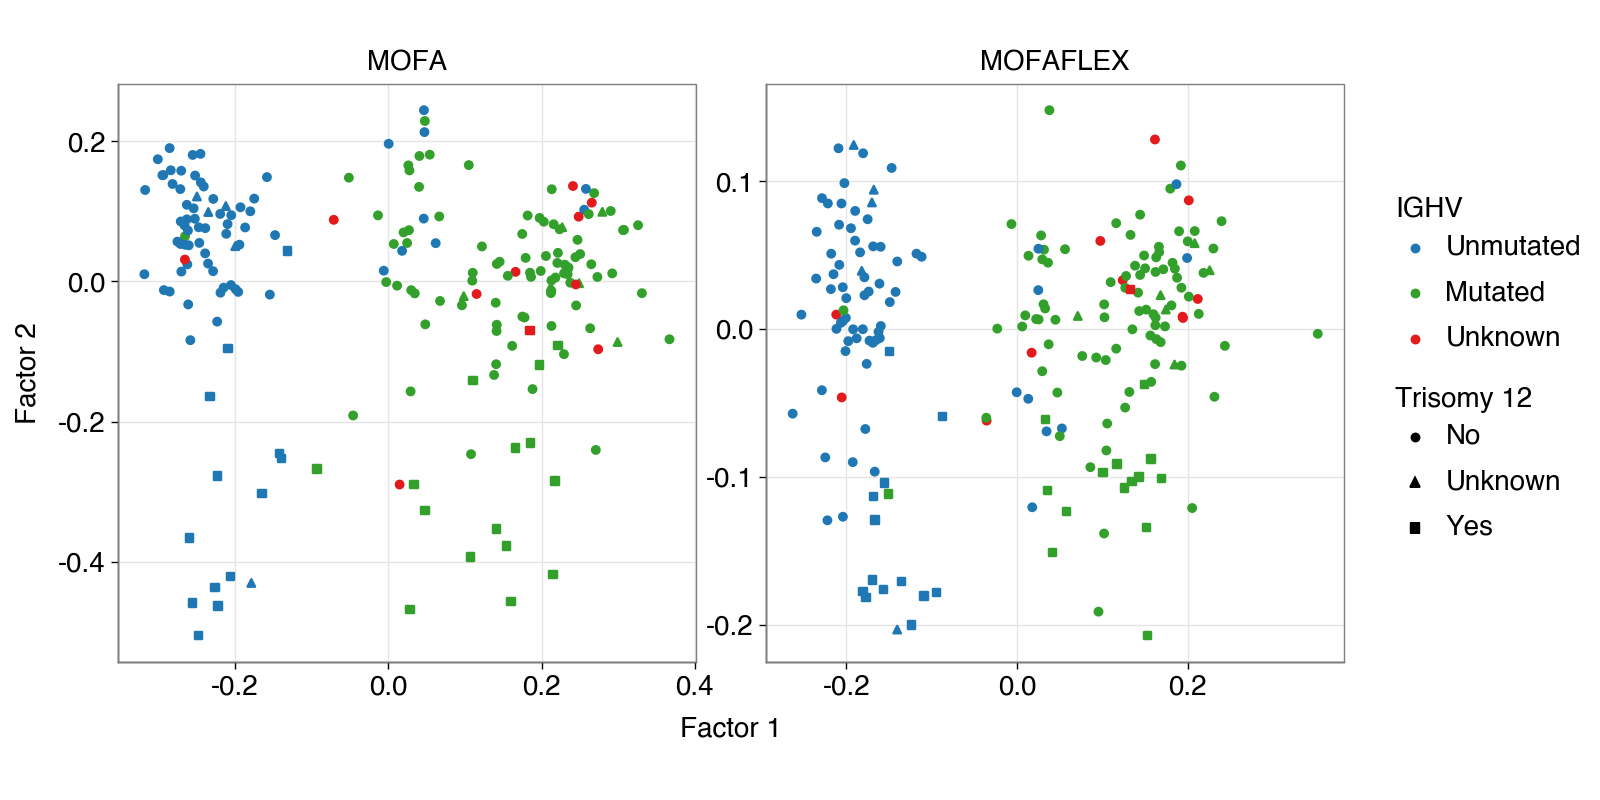

In [29]:
seed = 0

data = load_cll()
data.obs["trisomy12"] = data['Mutations'].to_df()["trisomy12"]
data.obs["IGHV"] = data['Mutations'].to_df()["IGHV"]

df_mofaflex = data.obs.copy()
df_mofaflex["Factor 1"] = z_mofaflex[seed]["Factor 1"]
df_mofaflex["Factor 2"] = z_mofaflex[seed]["Factor 2"]
df_mofaflex["Model"] = "MOFAFLEX"

df_mofa = df_mofaflex[["IGHV", "trisomy12"]].copy()
df_mofa["Factor 1"] = z_mofa["Factor 1"]
df_mofa["Factor 2"] = z_mofa["Factor 2"]
df_mofa["Model"] = "MOFA"

df = pd.concat([df_mofaflex, df_mofa], ignore_index=True)

df["trisomy12"] = df["trisomy12"].replace({0.0 : "No", 1.0 : "Yes"})
df["IGHV"] = df["IGHV"].replace({0.0 : "Unmutated", 1.0 : "Mutated"})
df.fillna("Unknown", inplace=True)

df["IGHV"] = pd.Categorical(df["IGHV"], categories=["Unmutated", "Mutated", "Unknown"], ordered=True)

plot = (
    ggplot(df, aes(x="Factor 1", y="Factor 2", color="IGHV", shape="trisomy12", group="Model"))
    + geom_point(size=1)
    + labs(x="Factor 1", y="Factor 2", color="IGHV", shape="Trisomy 12", title="")
    + theme(figure_size=(8, 4), legend_position="right")
    + facet_wrap("~Model", scales="free")
    + plotting_settings.discrete_scale_color
)

ggsave(plot, f"plots/mutations_factors.pdf")
plot.show()